In [2]:
#!pip install lvis

In [3]:
import json
import random
import matplotlib.pyplot as plt
import cv2
from lvis import LVIS

In [8]:
# ---- CONFIG ----
base_dir = "/BS/generative_modelling_for_image_understanding/nobackup/data/DETECTRON2_DATASETS/"
train_json = base_dir+"lvis/annotations/lvis_v1_train.json"
val_json   = base_dir+"lvis/annotations/lvis_v1_val.json"
img_root   = base_dir+"coco/train2017"   # LVIS images use COCO 2017 images
n_vis = 3   # number of samples to visualize per tier
# ---------------

In [5]:
def get_stats(lvis_obj, split_name="train"):
    cats = lvis_obj.load_cats(lvis_obj.get_cat_ids())
    cats_by_tier = {"c": [], "f": [], "r": []}
    for c in cats:
        cats_by_tier[c["frequency"]].append(c["id"])

    ann_counts = {"c": 0, "f": 0, "r": 0}
    for ann in lvis_obj.anns.values():
        tier = lvis_obj.load_cats([ann["category_id"]])[0]["frequency"]
        ann_counts[tier] += 1

    img_sets = {"c": set(), "f": set(), "r": set()}
    for t, ids in cats_by_tier.items():
        for cid in ids:
            img_sets[t].update(lvis_obj.cat_img_map[cid])
    img_counts = {t: len(img_sets[t]) for t in img_sets}

    stats = {
        "split": split_name,
        "num_classes": {t: len(cats_by_tier[t]) for t in cats_by_tier},
        "num_annotations": ann_counts,
        "num_images": img_counts,
        "total_classes": len(cats),
        "total_annotations": len(lvis_obj.anns),
        "total_images": len(lvis_obj.imgs)
    }
    return stats, cats_by_tier

In [12]:
# ---- Plots: Tier distributions ----
def plot_tier_distributions(train_stats, val_stats, save_path="lvis_tier_stats.png"):
    tiers = ["c","f","r"]
    labels = ["Common","Frequent","Rare"]

    fig, axes = plt.subplots(1, 3, figsize=(18,5))

    # Classes
    tr = [train_stats["num_classes"][t] for t in tiers]
    va = [val_stats["num_classes"][t] for t in tiers]
    x = range(len(tiers))
    axes[0].bar(x, tr, width=0.4, label="Train", align="center")
    axes[0].bar([i+0.4 for i in x], va, width=0.4, label="Val", align="center")
    axes[0].set_xticks([i+0.2 for i in x])
    axes[0].set_xticklabels(labels)
    axes[0].set_title("Number of Classes")
    axes[0].legend()

    # Annotations
    tr = [train_stats["num_annotations"][t] for t in tiers]
    va = [val_stats["num_annotations"][t] for t in tiers]
    axes[1].bar(x, tr, width=0.4, label="Train")
    axes[1].bar([i+0.4 for i in x], va, width=0.4, label="Val")
    axes[1].set_xticks([i+0.2 for i in x])
    axes[1].set_xticklabels(labels)
    axes[1].set_title("Number of Annotations")
    axes[1].legend()

    # Images
    tr = [train_stats["num_images"][t] for t in tiers]
    va = [val_stats["num_images"][t] for t in tiers]
    axes[2].bar(x, tr, width=0.4, label="Train")
    axes[2].bar([i+0.4 for i in x], va, width=0.4, label="Val")
    axes[2].set_xticks([i+0.2 for i in x])
    axes[2].set_xticklabels(labels)
    axes[2].set_title("Number of Images")
    axes[2].legend()

    plt.suptitle("LVIS v1 Tier Distributions: Train vs Val", fontsize=16)
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()

In [17]:
# ---- Visualization: sample images ----
def visualize_samples(lvis_obj, cats_by_tier, img_root, n_vis=3):
    color_map = {"c": (0,255,0), "f": (255,165,0), "r": (255,0,0)}  # green/orange/red
    for tier, cat_ids in cats_by_tier.items():
        print(f"\nTier {tier.upper()} ({len(cat_ids)} classes) — visualizing {n_vis} random samples")
        # pick random categories from tier
        chosen_cats = random.sample(cat_ids, min(len(cat_ids), 3))
        img_ids = set()
        for cid in chosen_cats:
            img_ids.update(lvis_obj.cat_img_map[cid])
        img_ids = list(img_ids)
        random.shuffle(img_ids)
        for im_id in img_ids[:n_vis]:
            img_info = lvis_obj.load_imgs([im_id])[0]
            img_path = f"{img_root}/{img_info['coco_url'].split('/')[-1]}"
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            ann_ids = lvis_obj.get_ann_ids([im_id])
            anns = lvis_obj.load_anns(ann_ids)
            for ann in anns:
                x,y,w,h = map(int, ann["bbox"])
                tier = lvis_obj.load_cats([ann["category_id"]])[0]["frequency"]
                color = color_map[tier]
                cv2.rectangle(img, (x,y), (x+w,y+h), color, 2)
            plt.figure(figsize=(8,6))
            plt.imshow(img); plt.axis("off")
            plt.title(f"Tier {tier.upper()} — Image {im_id}")
            plt.show()

In [9]:
# ---- Load LVIS ----
lvis_train = LVIS(train_json)
lvis_val   = LVIS(val_json)

In [11]:
train_stats, train_cats_by_tier = get_stats(lvis_train, "train")
val_stats,   val_cats_by_tier   = get_stats(lvis_val, "val")

In [15]:
print("Train stats:")
for k, v in train_stats.items():
    print(k, v)


print("Val stats:")
for k, v in val_stats.items():
    print(k, v)

Train stats:
split train
num_classes {'c': 461, 'f': 405, 'r': 337}
num_annotations {'c': 64626, 'f': 1200258, 'r': 5257}
num_images {'c': 15461, 'f': 98523, 'r': 1462}
total_classes 1203
total_annotations 1270141
total_images 100170
Val stats:
split val
num_classes {'c': 461, 'f': 405, 'r': 337}
num_annotations {'c': 13080, 'f': 230427, 'r': 1200}
num_images {'c': 3073, 'f': 19442, 'r': 322}
total_classes 1203
total_annotations 244707
total_images 19809


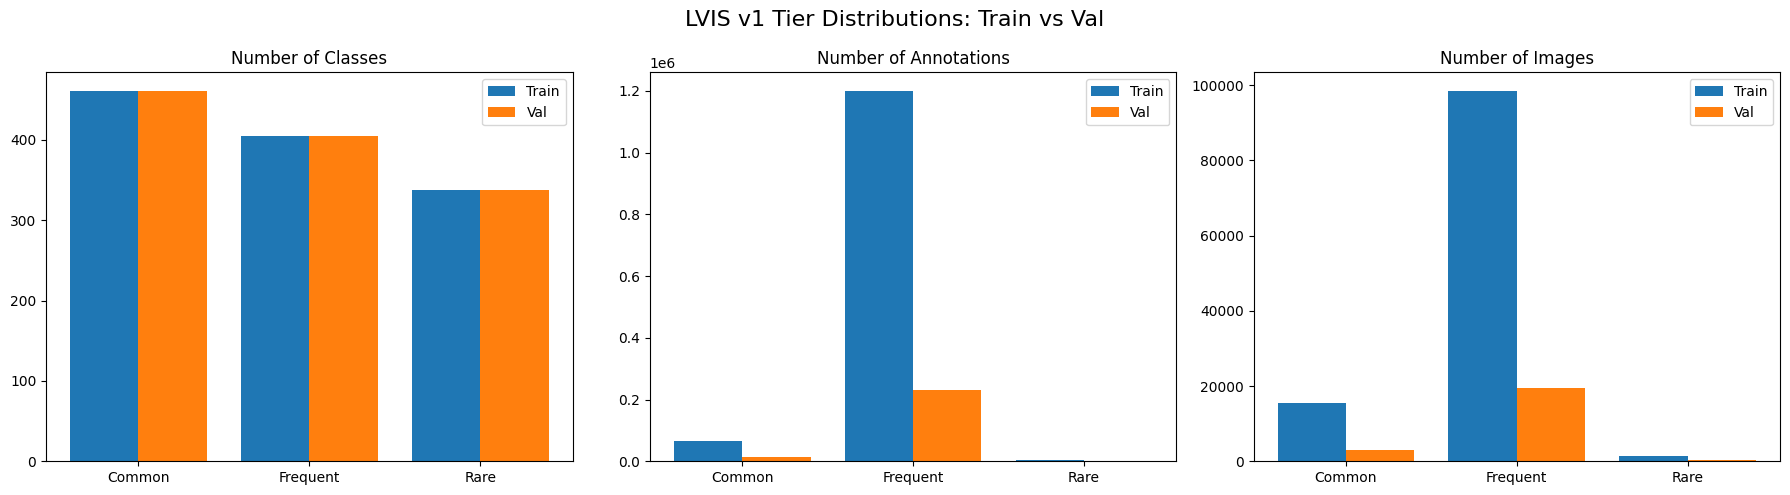

In [16]:
plot_tier_distributions(train_stats, val_stats)


Tier C (461 classes) — visualizing 3 random samples


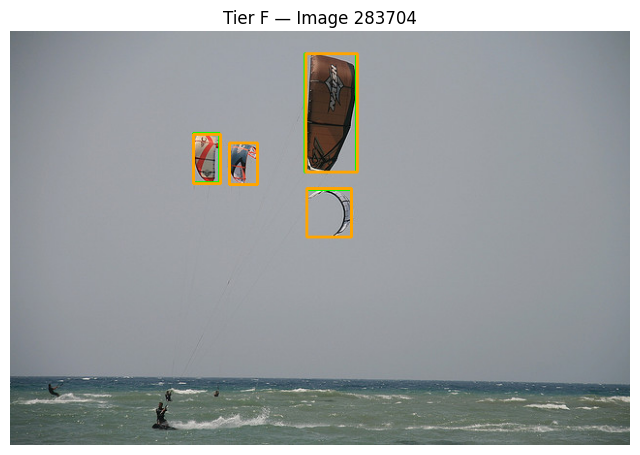

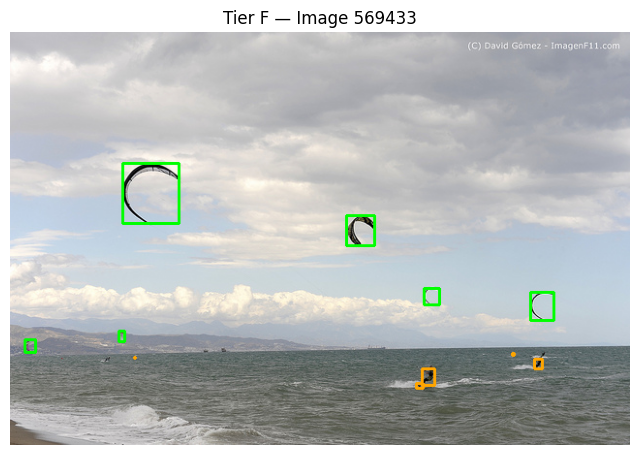

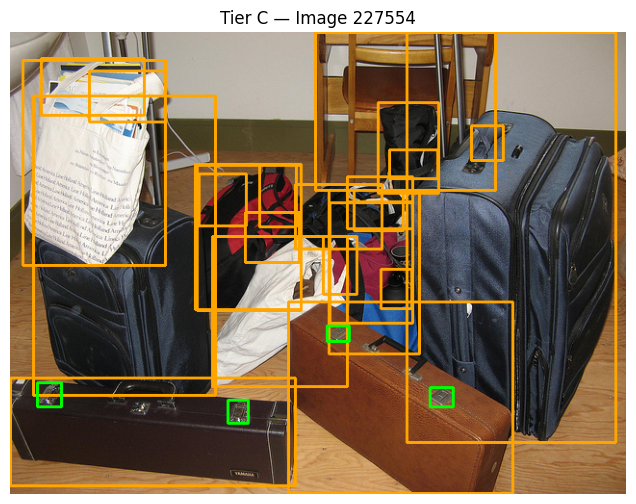


Tier F (405 classes) — visualizing 3 random samples


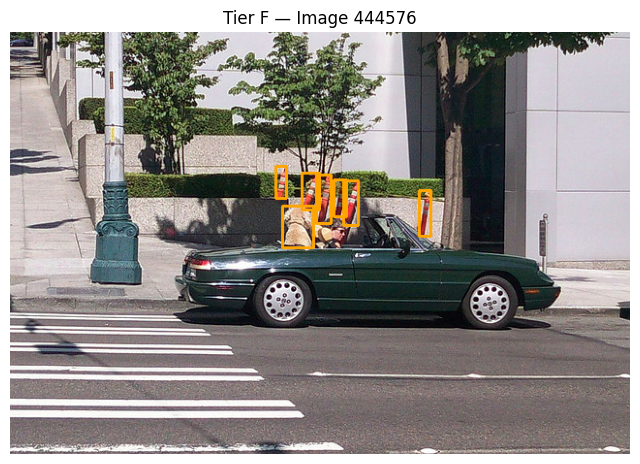

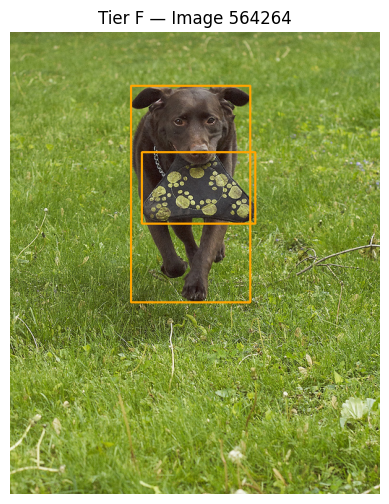

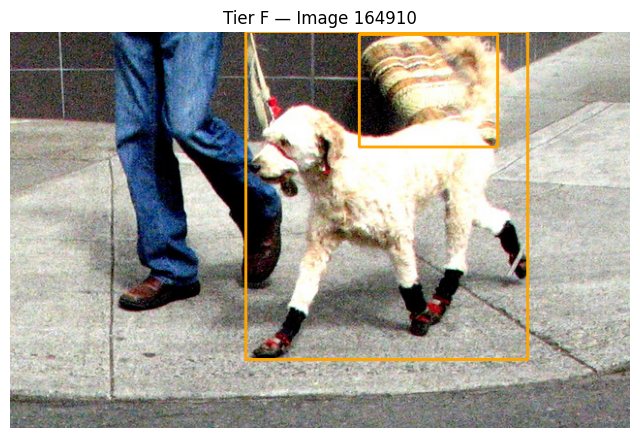


Tier R (337 classes) — visualizing 3 random samples


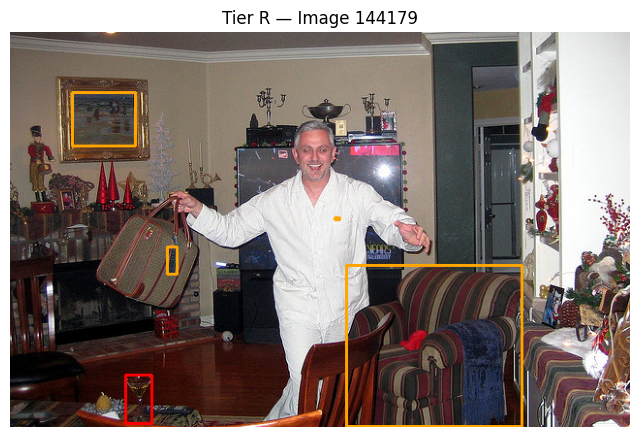

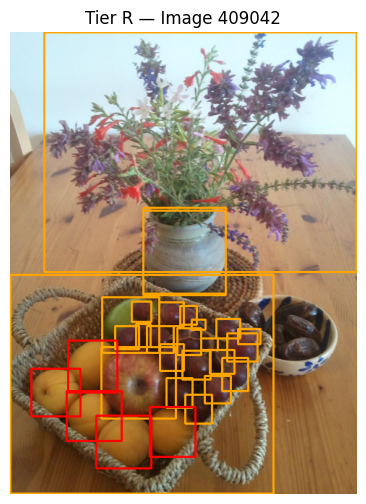

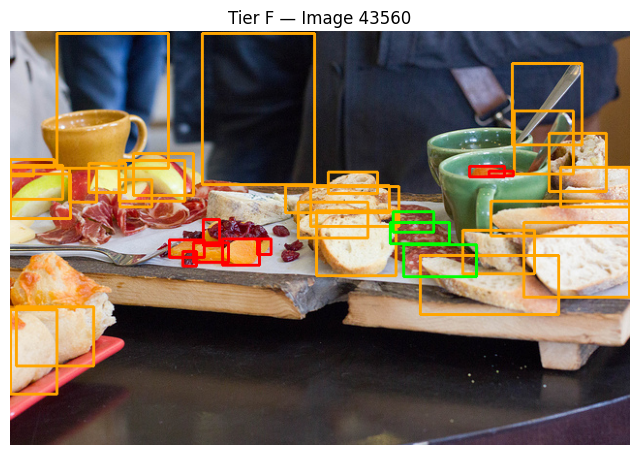

In [18]:
"""
Visualizations:
Random images from each tier with color-coded boxes:
🟩 Common
🟧 Frequent
🟥 Rare
"""
# Example: visualize from train
visualize_samples(lvis_train, train_cats_by_tier, img_root, n_vis=n_vis)